# Customer Churn Prediction using Machine learning

This project predicts customer churn using machine learning algorithms.

## Problem Definition
Given customer data, can we predict whether a customer will churn (leave) or stay with the service?

## Evaluation
Since customer churn prediction is often an imbalanced classification problem, we'll focus on:
- **Recall**: Maximize true positives (catch as many churning customers as possible) - PRIMARY METRIC
- **Precision**: Minimize false positives (customers incorrectly flagged as churning)
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Overall model performance on imbalanced data

In [1]:
# Import all necessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                            precision_score, recall_score, f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve)
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
import lightgbm as lgb

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 1: Load Data

Load the customer churn dataset from CSV file.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the customer churn dataset
# Update the path if your CSV file is in a different location

df = pd.read_csv(r'/content/drive/MyDrive/Customer_churn/Churn_Data.csv')



print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Shape: (10000, 14)

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2: Explore (EDA)

Explore the dataset to understand the data distribution, relationships, and patterns.

Target column: 'Exited'

Target Distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Target Distribution (%):
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


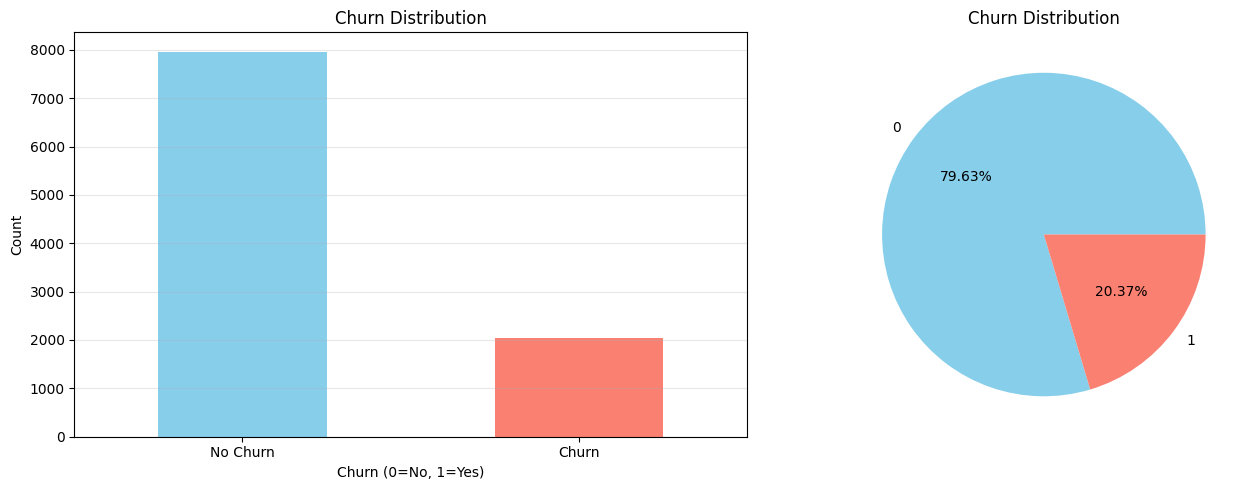


=== Dataset Statistics ===
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797 

In [6]:
# Find target column
target_candidates = ['Churn', 'churn', 'Exited', 'exited', 'target', 'Target']
target_col = None

for col in target_candidates:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    # Check if last column might be target
    target_col = df.columns[-1]
    print(f"Using last column '{target_col}' as target")

print(f"Target column: '{target_col}'")
print(f"\nTarget Distribution:")
print(df[target_col].value_counts())
print(f"\nTarget Distribution (%):")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[target_col].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Churn Distribution')
axes[0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

df[target_col].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Churn Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Basic statistics
print("\n=== Dataset Statistics ===")
print(df.describe())

# Check for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical columns: {list(categorical_cols)}")

# Check for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(f"Numerical columns: {list(numerical_cols)}")

## Step 3: Handle Missing Values

Identify and handle missing values in the dataset.

In [7]:
# Check missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("\nNo missing values found in the dataset!")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")

    # Visualize missing values
    if missing_values.sum() > 0:
        plt.figure(figsize=(12, 6))
        missing_values[missing_values > 0].plot(kind='bar')
        plt.title('Missing Values by Column')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Fill missing values
    # For numerical columns: fill with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled {col} with median: {df[col].median():.2f}")

    # For categorical columns: fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_value, inplace=True)
            print(f"Filled {col} with mode: {mode_value}")

    print("\nMissing values after handling:")
    print(df.isnull().sum().sum(), "total missing values remaining")

Missing values per column:
Series([], dtype: int64)

No missing values found in the dataset!


## Step 4: Split Data and Encode Categorical Features

Split data into train/validation/test sets FIRST, then encode categorical variables to avoid data leakage.

In [8]:
# Prepare features and target
# Rename target column to 'churn' for consistency
if target_col != 'churn':
    df.rename(columns={target_col: 'churn'}, inplace=True)

X = df.drop('churn', axis=1)
y = df['churn']

print(f"Original features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data FIRST into train/validation/test (60/20/20 split)
# First split: separate out test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: split remaining data into train (75% of 80% = 60%) and validation (25% of 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 0.8 = 0.2 total
)

print(f"\nData split completed:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining churn distribution:")
print(y_train.value_counts())
print(f"\nValidation churn distribution:")
print(y_val.value_counts())
print(f"\nTest churn distribution:")
print(y_test.value_counts())

# Now encode categorical features - fit on training data only to avoid data leakage
categorical_cols = X_train.select_dtypes(include=['object']).columns

if len(categorical_cols) > 0:
    print(f"\nEncoding {len(categorical_cols)} categorical columns: {list(categorical_cols)}")

    # Get all unique categories from training data
    # Use pd.get_dummies on training data
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dummy_na=False)

    # For validation and test, use the same columns as training
    # Reindex to match training columns and fill missing with 0
    X_val_encoded = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True, dummy_na=False)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dummy_na=False)

    # Align columns - add missing columns (from train) to val/test with 0s
    # Remove columns in val/test that don't exist in train
    X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    X_train = X_train_encoded
    X_val = X_val_encoded
    X_test = X_test_encoded

    print(f"After encoding: {X_train.shape[1]} features")
    print(f"Training features shape: {X_train.shape}")
    print(f"Validation features shape: {X_val.shape}")
    print(f"Test features shape: {X_test.shape}")
else:
    print("\nNo categorical columns found - all features are already numerical")

print(f"\nFeature columns: {list(X_train.columns[:10])}...")  # Show first 10

Original features shape: (10000, 13)
Target shape: (10000,)

Data split completed:
  Training set: 6000 samples (60.0%)
  Validation set: 2000 samples (20.0%)
  Test set: 2000 samples (20.0%)

Training churn distribution:
churn
0    4777
1    1223
Name: count, dtype: int64

Validation churn distribution:
churn
0    1593
1     407
Name: count, dtype: int64

Test churn distribution:
churn
0    1593
1     407
Name: count, dtype: int64

Encoding 3 categorical columns: ['Surname', 'Geography', 'Gender']
After encoding: 2248 features
Training features shape: (6000, 2248)
Validation features shape: (2000, 2248)
Test features shape: (2000, 2248)

Feature columns: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']...


## Step 5: Scale Numerical Features

Standardize numerical features to have similar scales. Fit scaler on training data only.

In [9]:
# Scale features - fit on training data only, then transform all sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Features scaled successfully!
Scaled training set shape: (6000, 2248)
Scaled validation set shape: (2000, 2248)
Scaled test set shape: (2000, 2248)


## Step 6: Handle Imbalance

Address class imbalance using class_weight or sample_weight.

In [10]:
# Check class imbalance
churn_counts = y_train.value_counts()
churn_ratio = churn_counts[0] / churn_counts[1] if len(churn_counts) > 1 else 1

print(f"Class distribution:")
print(f"  No Churn (0): {churn_counts[0]} ({(churn_counts[0]/len(y_train)*100):.2f}%)")
print(f"  Churn (1): {churn_counts[1]} ({(churn_counts[1]/len(y_train)*100):.2f}%)")
print(f"  Imbalance ratio: {churn_ratio:.2f}:1")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"\nClass weights: {class_weight_dict}")

# Calculate sample weights
sample_weights = compute_sample_weight('balanced', y_train)

print(f"\nSample weights calculated for {len(sample_weights)} training samples")
print(f"Sample weight range: [{sample_weights.min():.4f}, {sample_weights.max():.4f}]")

Class distribution:
  No Churn (0): 4777 (79.62%)
  Churn (1): 1223 (20.38%)
  Imbalance ratio: 3.91:1

Class weights: {np.int64(0): np.float64(0.6280092108017584), np.int64(1): np.float64(2.4529844644317254)}

Sample weights calculated for 6000 training samples
Sample weight range: [0.6280, 2.4530]


## Step 7: Train Models

Train multiple models on training set and evaluate on validation set: Logistic Regression, Random Forest, XGBoost, and LightGBM.

In [11]:
# Initialize models dictionary to store results
models = {}
predictions = {}
probabilities = {}

# 1. Logistic Regression with class_weight
print("=" * 60)
print("Training Logistic Regression...")
print("=" * 60)
lr_model = LogisticRegression(random_state=42, max_iter=1000,
                               class_weight='balanced', n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
# Evaluate on VALIDATION set (not test set)
lr_pred = lr_model.predict(X_val_scaled)
lr_pred_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = lr_pred
probabilities['Logistic Regression'] = lr_pred_proba

lr_recall = recall_score(y_val, lr_pred)
lr_precision = precision_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)
lr_roc_auc = roc_auc_score(y_val, lr_pred_proba)
lr_accuracy = accuracy_score(y_val, lr_pred)

print(f"Recall (Validation): {lr_recall:.4f}")
print(f"Precision (Validation): {lr_precision:.4f}")
print(f"F1-Score (Validation): {lr_f1:.4f}")
print(f"ROC-AUC (Validation): {lr_roc_auc:.4f}")
print(f"Accuracy (Validation): {lr_accuracy:.4f}")
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, lr_pred))

Training Logistic Regression...
Recall (Validation): 0.4079
Precision (Validation): 0.3223
F1-Score (Validation): 0.3601
ROC-AUC (Validation): 0.6231
Accuracy (Validation): 0.7050

Confusion Matrix (Validation):
[[1244  349]
 [ 241  166]]


In [12]:
# 2. Random Forest with class_weight
print("=" * 60)
print("Training Random Forest...")
print("=" * 60)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                   class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
# Evaluate on VALIDATION set (not test set)
rf_pred = rf_model.predict(X_val_scaled)
rf_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]

models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_pred
probabilities['Random Forest'] = rf_pred_proba

rf_recall = recall_score(y_val, rf_pred)
rf_precision = precision_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)
rf_roc_auc = roc_auc_score(y_val, rf_pred_proba)
rf_accuracy = accuracy_score(y_val, rf_pred)

print(f"Recall (Validation): {rf_recall:.4f}")
print(f"Precision (Validation): {rf_precision:.4f}")
print(f"F1-Score (Validation): {rf_f1:.4f}")
print(f"ROC-AUC (Validation): {rf_roc_auc:.4f}")
print(f"Accuracy (Validation): {rf_accuracy:.4f}")
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, rf_pred))

Training Random Forest...
Recall (Validation): 0.2948
Precision (Validation): 0.8571
F1-Score (Validation): 0.4388
ROC-AUC (Validation): 0.8428
Accuracy (Validation): 0.8465

Confusion Matrix (Validation):
[[1573   20]
 [ 287  120]]


In [13]:
# 3. XGBoost with sample_weight
print("=" * 60)
print("Training XGBoost...")
print("=" * 60)
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
# Evaluate on VALIDATION set (not test set)
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]

models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_pred
probabilities['XGBoost'] = xgb_pred_proba

xgb_recall = recall_score(y_val, xgb_pred)
xgb_precision = precision_score(y_val, xgb_pred)
xgb_f1 = f1_score(y_val, xgb_pred)
xgb_roc_auc = roc_auc_score(y_val, xgb_pred_proba)
xgb_accuracy = accuracy_score(y_val, xgb_pred)

print(f"Recall (Validation): {xgb_recall:.4f}")
print(f"Precision (Validation): {xgb_precision:.4f}")
print(f"F1-Score (Validation): {xgb_f1:.4f}")
print(f"ROC-AUC (Validation): {xgb_roc_auc:.4f}")
print(f"Accuracy (Validation): {xgb_accuracy:.4f}")
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, xgb_pred))

Training XGBoost...
Recall (Validation): 0.6388
Precision (Validation): 0.5628
F1-Score (Validation): 0.5984
ROC-AUC (Validation): 0.8480
Accuracy (Validation): 0.8255

Confusion Matrix (Validation):
[[1391  202]
 [ 147  260]]


In [14]:
# 4. LightGBM with sample_weight
print("=" * 60)
print("Training LightGBM...")
print("=" * 60)
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
# Evaluate on VALIDATION set (not test set)
lgb_pred = lgb_model.predict(X_val_scaled)
lgb_pred_proba = lgb_model.predict_proba(X_val_scaled)[:, 1]

models['LightGBM'] = lgb_model
predictions['LightGBM'] = lgb_pred
probabilities['LightGBM'] = lgb_pred_proba

lgb_recall = recall_score(y_val, lgb_pred)
lgb_precision = precision_score(y_val, lgb_pred)
lgb_f1 = f1_score(y_val, lgb_pred)
lgb_roc_auc = roc_auc_score(y_val, lgb_pred_proba)
lgb_accuracy = accuracy_score(y_val, lgb_pred)

print(f"Recall (Validation): {lgb_recall:.4f}")
print(f"Precision (Validation): {lgb_precision:.4f}")
print(f"F1-Score (Validation): {lgb_f1:.4f}")
print(f"ROC-AUC (Validation): {lgb_roc_auc:.4f}")
print(f"Accuracy (Validation): {lgb_accuracy:.4f}")
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, lgb_pred))

Training LightGBM...
Recall (Validation): 0.6683
Precision (Validation): 0.5690
F1-Score (Validation): 0.6147
ROC-AUC (Validation): 0.8543
Accuracy (Validation): 0.8295

Confusion Matrix (Validation):
[[1387  206]
 [ 135  272]]


## Step 8: Hyperparameter Tuning

Optimize hyperparameters for each model using GridSearchCV or RandomizedSearchCV with Recall as scoring metric.

In [15]:
# Tune Logistic Regression using validation set
print("=" * 60)
print("Tuning Logistic Regression...")
print("=" * 60)
lr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

lr_grid = RandomizedSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1),
    lr_param_grid,
    n_iter=50,
    cv=3,
    scoring='recall',  # Using Recall as primary metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on training set, tune using cross-validation
lr_grid.fit(X_train_scaled, y_train)
print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV Recall: {lr_grid.best_score_:.4f}")

# Evaluate on validation set
lr_best = lr_grid.best_estimator_
lr_val_pred = lr_best.predict(X_val_scaled)
lr_val_pred_proba = lr_best.predict_proba(X_val_scaled)[:, 1]

lr_val_recall = recall_score(y_val, lr_val_pred)
lr_val_precision = precision_score(y_val, lr_val_pred)
lr_val_f1 = f1_score(y_val, lr_val_pred)
lr_val_roc_auc = roc_auc_score(y_val, lr_val_pred_proba)
lr_val_accuracy = accuracy_score(y_val, lr_val_pred)

print("\n=== Tuned Logistic Regression (Validation Set) ===")
print(f"Recall: {lr_val_recall:.4f}")
print(f"Precision: {lr_val_precision:.4f}")
print(f"F1-Score: {lr_val_f1:.4f}")
print(f"ROC-AUC: {lr_val_roc_auc:.4f}")
print(f"Accuracy: {lr_val_accuracy:.4f}")

# Store for final test evaluation later
lr_best_pred_proba = None  # Will be set after threshold tuning

Tuning Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in 


Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Best CV Recall: 0.5021

=== Tuned Logistic Regression (Validation Set) ===
Recall: 0.4398
Precision: 0.3249
F1-Score: 0.3737
ROC-AUC: 0.6472
Accuracy: 0.7000


In [16]:
# Tune Random Forest using validation set
print("=" * 60)
print("Tuning Random Forest...")
print("=" * 60)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    rf_param_grid,
    n_iter=50,
    cv=3,
    scoring='recall',  # Using Recall as primary metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on training set, tune using cross-validation
rf_grid.fit(X_train_scaled, y_train)
print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV Recall: {rf_grid.best_score_:.4f}")

# Evaluate on validation set
rf_best = rf_grid.best_estimator_
rf_val_pred = rf_best.predict(X_val_scaled)
rf_val_pred_proba = rf_best.predict_proba(X_val_scaled)[:, 1]

rf_val_recall = recall_score(y_val, rf_val_pred)
rf_val_precision = precision_score(y_val, rf_val_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred)
rf_val_roc_auc = roc_auc_score(y_val, rf_val_pred_proba)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)

print("\n=== Tuned Random Forest (Validation Set) ===")
print(f"Recall: {rf_val_recall:.4f}")
print(f"Precision: {rf_val_precision:.4f}")
print(f"F1-Score: {rf_val_f1:.4f}")
print(f"ROC-AUC: {rf_val_roc_auc:.4f}")
print(f"Accuracy: {rf_val_accuracy:.4f}")

# Store for final test evaluation later
rf_best_pred_proba = None  # Will be set after threshold tuning

Tuning Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}
Best CV Recall: 0.7032

=== Tuned Random Forest (Validation Set) ===
Recall: 0.7002
Precision: 0.4790
F1-Score: 0.5689
ROC-AUC: 0.8256
Accuracy: 0.7840


In [17]:
# Tune XGBoost using validation set
print("=" * 60)
print("Tuning XGBoost...")
print("=" * 60)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    xgb_param_grid,
    n_iter=50,
    cv=3,
    scoring='recall',  # Using Recall as primary metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on training set, tune using cross-validation
xgb_grid.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV Recall: {xgb_grid.best_score_:.4f}")

# Evaluate on validation set
xgb_best = xgb_grid.best_estimator_
xgb_val_pred = xgb_best.predict(X_val_scaled)
xgb_val_pred_proba = xgb_best.predict_proba(X_val_scaled)[:, 1]

xgb_val_recall = recall_score(y_val, xgb_val_pred)
xgb_val_precision = precision_score(y_val, xgb_val_pred)
xgb_val_f1 = f1_score(y_val, xgb_val_pred)
xgb_val_roc_auc = roc_auc_score(y_val, xgb_val_pred_proba)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_pred)

print("\n=== Tuned XGBoost (Validation Set) ===")
print(f"Recall: {xgb_val_recall:.4f}")
print(f"Precision: {xgb_val_precision:.4f}")
print(f"F1-Score: {xgb_val_f1:.4f}")
print(f"ROC-AUC: {xgb_val_roc_auc:.4f}")
print(f"Accuracy: {xgb_val_accuracy:.4f}")

# Store for final test evaluation later
xgb_best_pred_proba = None  # Will be set after threshold tuning

Tuning XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV Recall: 0.7367

=== Tuned XGBoost (Validation Set) ===
Recall: 0.7543
Precision: 0.5108
F1-Score: 0.6091
ROC-AUC: 0.8592
Accuracy: 0.8030


In [18]:
# Tune LightGBM using validation set
print("=" * 60)
print("Tuning LightGBM...")
print("=" * 60)
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'num_leaves': [31, 50, 70]
}

lgb_grid = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    lgb_param_grid,
    n_iter=50,
    cv=3,
    scoring='recall',  # Using Recall as primary metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on training set, tune using cross-validation
lgb_grid.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print(f"\nBest parameters: {lgb_grid.best_params_}")
print(f"Best CV Recall: {lgb_grid.best_score_:.4f}")

# Evaluate on validation set
lgb_best = lgb_grid.best_estimator_
lgb_val_pred = lgb_best.predict(X_val_scaled)
lgb_val_pred_proba = lgb_best.predict_proba(X_val_scaled)[:, 1]

lgb_val_recall = recall_score(y_val, lgb_val_pred)
lgb_val_precision = precision_score(y_val, lgb_val_pred)
lgb_val_f1 = f1_score(y_val, lgb_val_pred)
lgb_val_roc_auc = roc_auc_score(y_val, lgb_val_pred_proba)
lgb_val_accuracy = accuracy_score(y_val, lgb_val_pred)

print("\n=== Tuned LightGBM (Validation Set) ===")
print(f"Recall: {lgb_val_recall:.4f}")
print(f"Precision: {lgb_val_precision:.4f}")
print(f"F1-Score: {lgb_val_f1:.4f}")
print(f"ROC-AUC: {lgb_val_roc_auc:.4f}")
print(f"Accuracy: {lgb_val_accuracy:.4f}")

# Store for final test evaluation later
lgb_best_pred_proba = None  # Will be set after threshold tuning

Tuning LightGBM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best parameters: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV Recall: 0.7392

=== Tuned LightGBM (Validation Set) ===
Recall: 0.7469
Precision: 0.4967
F1-Score: 0.5967
ROC-AUC: 0.8582
Accuracy: 0.7945


## Step 9: Threshold Tuning

Optimize the classification threshold on validation set to maximize Recall while maintaining reasonable Precision.

In [19]:
# Function to find optimal threshold for maximum recall
def find_optimal_threshold(y_true, y_proba, metric='recall'):
    """Find optimal threshold that maximizes the specified metric"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        if metric == 'recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'f1':
            score = f1_score(y_true, y_pred)
        else:
            score = recall_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# Get probabilities on validation set for threshold tuning
lr_val_pred_proba = lr_best.predict_proba(X_val_scaled)[:, 1]
rf_val_pred_proba = rf_best.predict_proba(X_val_scaled)[:, 1]
xgb_val_pred_proba = xgb_best.predict_proba(X_val_scaled)[:, 1]
lgb_val_pred_proba = lgb_best.predict_proba(X_val_scaled)[:, 1]

# Find optimal thresholds on VALIDATION set
print("Finding optimal thresholds for maximum Recall on VALIDATION set...\n")

# Logistic Regression
lr_threshold, lr_best_recall_thresh = find_optimal_threshold(y_val, lr_val_pred_proba, 'recall')
lr_val_pred_thresh = (lr_val_pred_proba >= lr_threshold).astype(int)
print(f"Logistic Regression - Optimal threshold: {lr_threshold:.3f}")
print(f"  Recall at threshold: {recall_score(y_val, lr_val_pred_thresh):.4f}")
print(f"  Precision at threshold: {precision_score(y_val, lr_val_pred_thresh):.4f}")

# Random Forest
rf_threshold, rf_best_recall_thresh = find_optimal_threshold(y_val, rf_val_pred_proba, 'recall')
rf_val_pred_thresh = (rf_val_pred_proba >= rf_threshold).astype(int)
print(f"\nRandom Forest - Optimal threshold: {rf_threshold:.3f}")
print(f"  Recall at threshold: {recall_score(y_val, rf_val_pred_thresh):.4f}")
print(f"  Precision at threshold: {precision_score(y_val, rf_val_pred_thresh):.4f}")

# XGBoost
xgb_threshold, xgb_best_recall_thresh = find_optimal_threshold(y_val, xgb_val_pred_proba, 'recall')
xgb_val_pred_thresh = (xgb_val_pred_proba >= xgb_threshold).astype(int)
print(f"\nXGBoost - Optimal threshold: {xgb_threshold:.3f}")
print(f"  Recall at threshold: {recall_score(y_val, xgb_val_pred_thresh):.4f}")
print(f"  Precision at threshold: {precision_score(y_val, xgb_val_pred_thresh):.4f}")

# LightGBM
lgb_threshold, lgb_best_recall_thresh = find_optimal_threshold(y_val, lgb_val_pred_proba, 'recall')
lgb_val_pred_thresh = (lgb_val_pred_proba >= lgb_threshold).astype(int)
print(f"\nLightGBM - Optimal threshold: {lgb_threshold:.3f}")
print(f"  Recall at threshold: {recall_score(y_val, lgb_val_pred_thresh):.4f}")
print(f"  Precision at threshold: {precision_score(y_val, lgb_val_pred_thresh):.4f}")

# Now apply these thresholds to TEST set for final evaluation
print("\n" + "=" * 60)
print("Applying optimal thresholds to TEST set...")
print("=" * 60)

# Get probabilities on test set
lr_test_pred_proba = lr_best.predict_proba(X_test_scaled)[:, 1]
rf_test_pred_proba = rf_best.predict_proba(X_test_scaled)[:, 1]
xgb_test_pred_proba = xgb_best.predict_proba(X_test_scaled)[:, 1]
lgb_test_pred_proba = lgb_best.predict_proba(X_test_scaled)[:, 1]

# Apply thresholds to test set
lr_test_pred_thresh = (lr_test_pred_proba >= lr_threshold).astype(int)
rf_test_pred_thresh = (rf_test_pred_proba >= rf_threshold).astype(int)
xgb_test_pred_thresh = (xgb_test_pred_proba >= xgb_threshold).astype(int)
lgb_test_pred_thresh = (lgb_test_pred_proba >= lgb_threshold).astype(int)

# Store threshold-optimized predictions for test set
threshold_predictions = {
    'Logistic Regression': lr_test_pred_thresh,
    'Random Forest': rf_test_pred_thresh,
    'XGBoost': xgb_test_pred_thresh,
    'LightGBM': lgb_test_pred_thresh
}

# Store probabilities for test set
test_probabilities = {
    'Logistic Regression': lr_test_pred_proba,
    'Random Forest': rf_test_pred_proba,
    'XGBoost': xgb_test_pred_proba,
    'LightGBM': lgb_test_pred_proba
}

Finding optimal thresholds for maximum Recall on VALIDATION set...

Logistic Regression - Optimal threshold: 0.100
  Recall at threshold: 0.7445
  Precision at threshold: 0.2418

Random Forest - Optimal threshold: 0.100
  Recall at threshold: 1.0000
  Precision at threshold: 0.2035

XGBoost - Optimal threshold: 0.100
  Recall at threshold: 0.9730
  Precision at threshold: 0.2421

LightGBM - Optimal threshold: 0.100
  Recall at threshold: 0.9754
  Precision at threshold: 0.2424

Applying optimal thresholds to TEST set...


## Step 10: Evaluate Models on Test Set

Evaluate all models on the TEST set (unseen data) using Confusion Matrix, Precision/Recall, and ROC curves.

In [22]:
# Compile all results on TEST set
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']
tuned_models = [lr_best, rf_best, xgb_best, lgb_best]
test_probas = [lr_test_pred_proba, rf_test_pred_proba, xgb_test_pred_proba, lgb_test_pred_proba]
thresh_preds = [lr_test_pred_thresh, rf_test_pred_thresh, xgb_test_pred_thresh, lgb_test_pred_thresh]
standard_preds = [(proba >= 0.5).astype(int) for proba in test_probas]
# Calculate metrics for threshold-optimized predictions on TEST set
results = []
for i, name in enumerate(model_names):
    # Standard predictions (0.5 threshold)
    standard_pred = (test_probas[i] >= 0.5).astype(int)
    rec_std = recall_score(y_test, standard_pred)
    prec_std = precision_score(y_test, standard_pred)
    f1_std = f1_score(y_test, standard_pred)
    roc = roc_auc_score(y_test, test_probas[i])
    acc_std = accuracy_score(y_test, standard_pred)

    # Threshold-optimized predictions
    rec_thresh = recall_score(y_test, thresh_preds[i])
    prec_thresh = precision_score(y_test, thresh_preds[i])
    f1_thresh = f1_score(y_test, thresh_preds[i])
    acc_thresh = accuracy_score(y_test, thresh_preds[i])

    results.append({
        'Model': name,
        'Recall (Standard)': rec_std,
        'Precision (Standard)': prec_std,
        'F1 (Standard)': f1_std,
        'ROC-AUC': roc,
        'Accuracy (Standard)': acc_std,
        'Recall (Threshold)': rec_thresh,
        'Precision (Threshold)': prec_thresh,
        'F1 (Threshold)': f1_thresh,
        'Accuracy (Threshold)': acc_thresh
    })

results_df = pd.DataFrame(results)
print("=" * 80)
print("MODEL COMPARISON - TEST SET METRICS")
print("=" * 80)
print(results_df.round(4))

MODEL COMPARISON - TEST SET METRICS
                 Model  Recall (Standard)  Precision (Standard)  \
0  Logistic Regression             0.4373                0.3242   
1        Random Forest             0.7101                0.4617   
2              XGBoost             0.7494                0.4927   
3             LightGBM             0.7543                0.4960   

   F1 (Standard)  ROC-AUC  Accuracy (Standard)  Recall (Threshold)  \
0         0.3724   0.6352               0.7000              0.7420   
1         0.5595   0.8325               0.7725              1.0000   
2         0.5945   0.8655               0.7920              0.9853   
3         0.5984   0.8630               0.7940              0.9828   

   Precision (Threshold)  F1 (Threshold)  Accuracy (Threshold)  
0                 0.2397          0.3623                0.4685  
1                 0.2035          0.3382                0.2035  
2                 0.2410          0.3873                0.3655  
3                

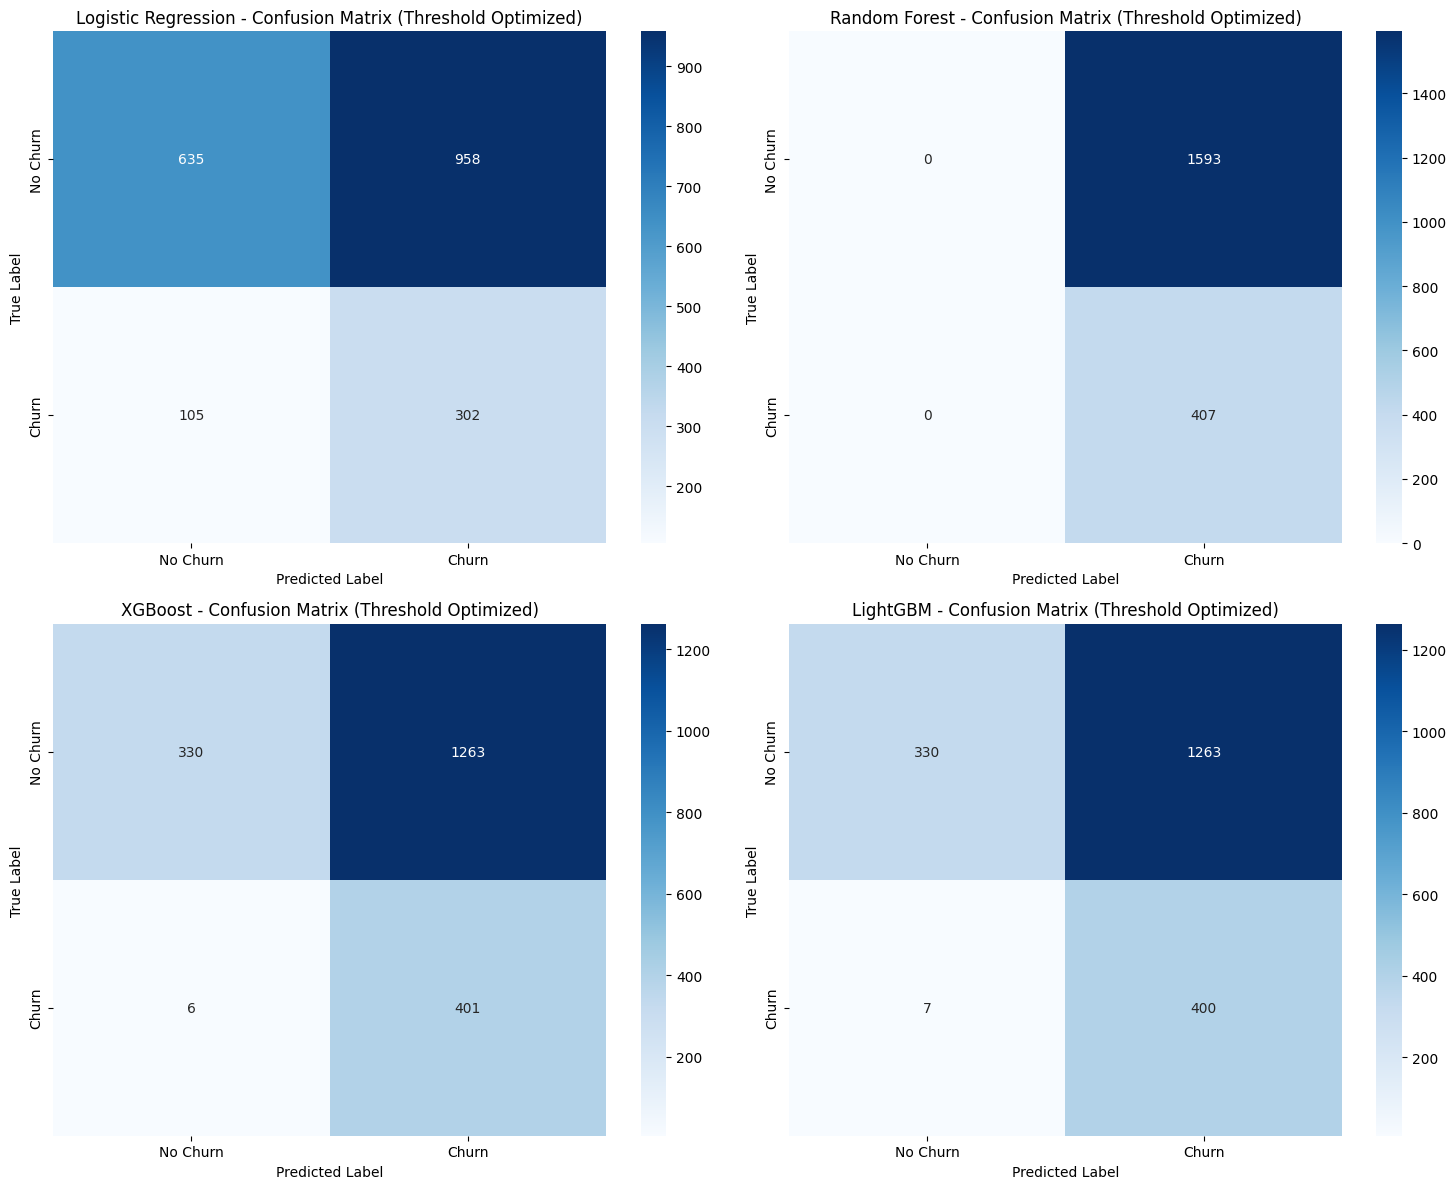

In [23]:
# Confusion Matrices for threshold-optimized predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, (name, pred) in enumerate(zip(model_names, thresh_preds)):
    row = i // 2
    col = i % 2
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    axes[row, col].set_title(f'{name} - Confusion Matrix (Threshold Optimized)')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

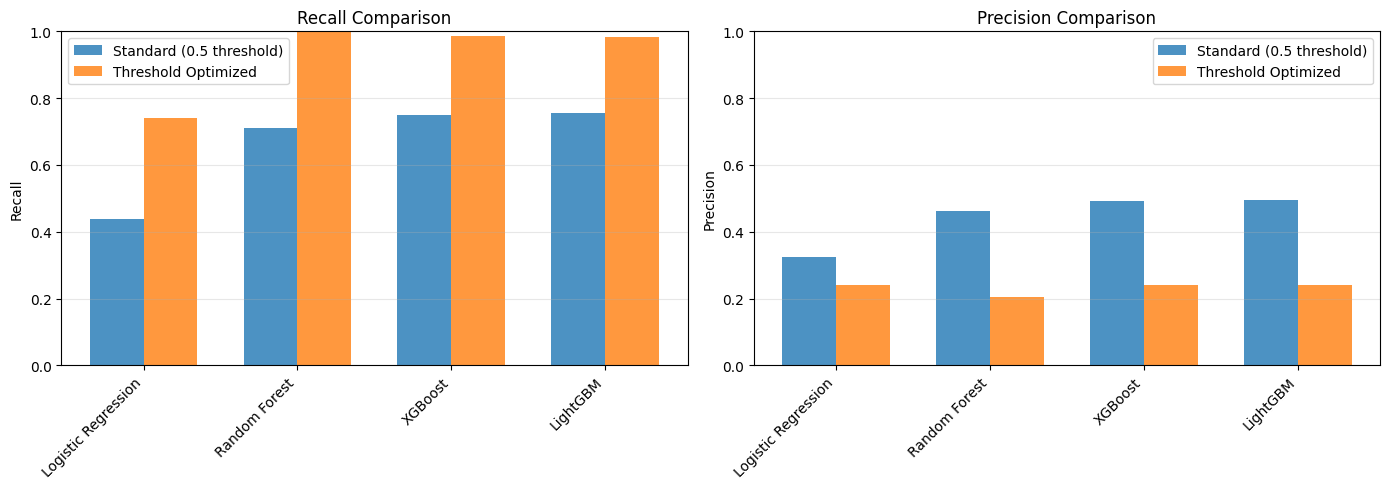

In [24]:
# Precision and Recall Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard predictions


recalls_std = [recall_score(y_test, pred) for pred in standard_preds]
precisions_std = [precision_score(y_test, pred) for pred in standard_preds]


# Threshold-optimized predictions
recalls_thresh = [recall_score(y_test, pred) for pred in thresh_preds]
precisions_thresh = [precision_score(y_test, pred) for pred in thresh_preds]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, recalls_std, width, label='Standard (0.5 threshold)', alpha=0.8)
axes[0].bar(x + width/2, recalls_thresh, width, label='Threshold Optimized', alpha=0.8)
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

axes[1].bar(x - width/2, precisions_std, width, label='Standard (0.5 threshold)', alpha=0.8)
axes[1].bar(x + width/2, precisions_thresh, width, label='Threshold Optimized', alpha=0.8)
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

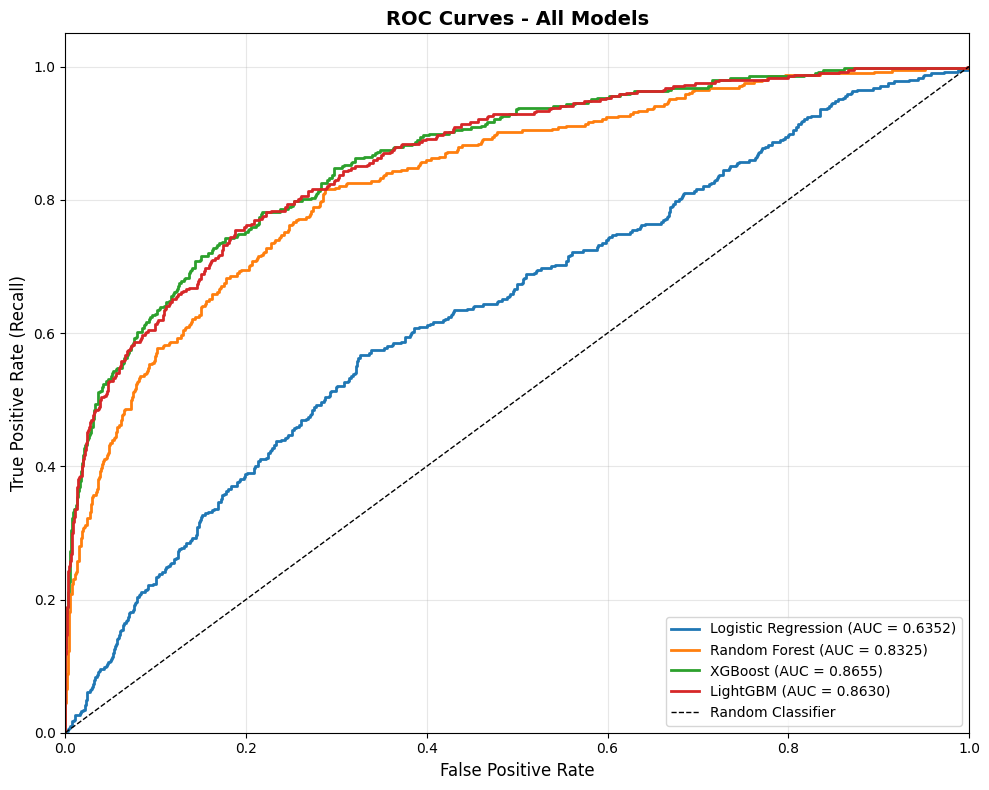

In [25]:
# ROC Curves
plt.figure(figsize=(10, 8))

for i, (name, proba) in enumerate(zip(model_names, test_probas)):
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Customer Churn Prediction

Predicts which customers are likely to churn.

TOP 15 MOST IMPORTANT FEATURES (Random Forest)
                feature  importance
3                   Age    0.247891
6         NumOfProducts    0.180992
8        IsActiveMember    0.086638
2245  Geography_Germany    0.073432
5               Balance    0.073136
2247        Gender_Male    0.035983
9       EstimatedSalary    0.022153
1            CustomerId    0.019135
2           CreditScore    0.018274
0             RowNumber    0.014126
2246    Geography_Spain    0.011950
4                Tenure    0.009125
7             HasCrCard    0.003700
1801        Surname_Sal    0.002199
1297     Surname_Martin    0.002193


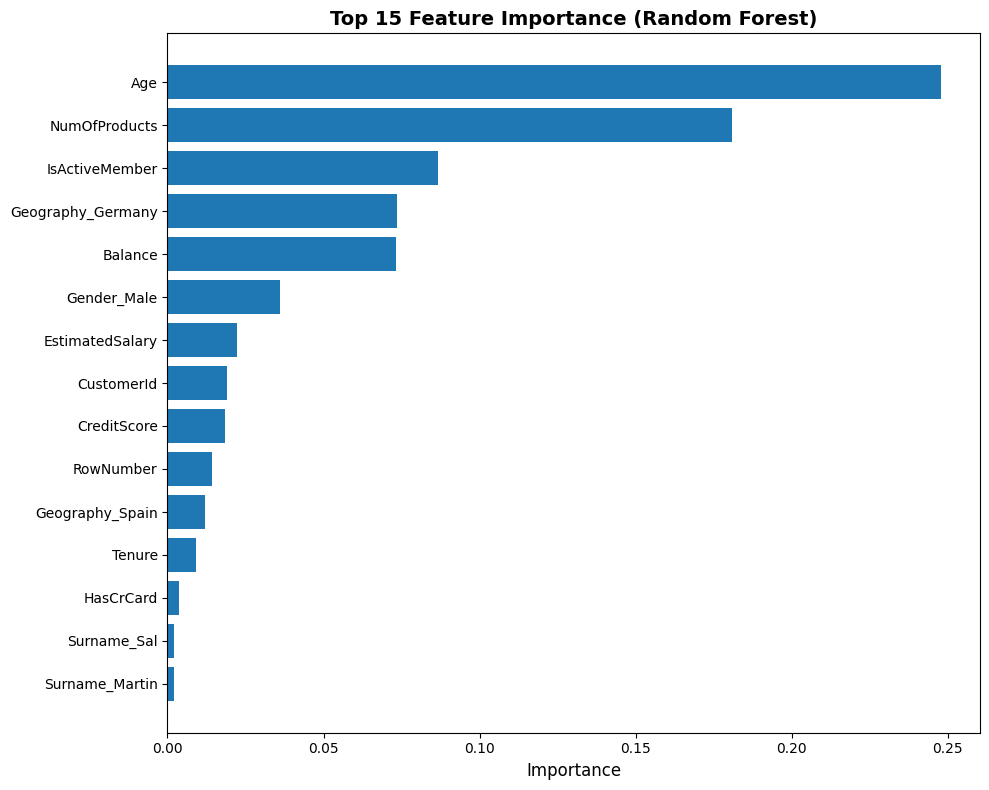

In [26]:
# Feature Importance (from Random Forest)
feature_imp = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 60)
print("TOP 15 MOST IMPORTANT FEATURES (Random Forest)")
print("=" * 60)
print(feature_imp.head(15))

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_imp.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Final Summary

Compare all models and identify the best performing model based on Recall (primary metric).

In [28]:
# Find best model based on Recall (threshold-optimized)
best_model_idx = np.argmax(recalls_thresh)
best_model_name = model_names[best_model_idx]

print("=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)
print(f"\nBest Model (by Recall): {best_model_name}")
print(f"  - Recall: {recalls_thresh[best_model_idx]:.4f} ({recalls_thresh[best_model_idx]*100:.2f}%)")
print(f"  - Precision: {precisions_thresh[best_model_idx]:.4f} ({precisions_thresh[best_model_idx]*100:.2f}%)")
print(f"  - F1-Score: {f1_score(y_test, thresh_preds[best_model_idx]):.4f}")
print(f"  - ROC-AUC: {roc_auc_score(y_test, test_probas[best_model_idx]):.4f}")
print(f"  - Accuracy: {accuracy_score(y_test, thresh_preds[best_model_idx]):.4f} ({accuracy_score(y_test, thresh_preds[best_model_idx])*100:.2f}%)")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n1. All models trained and tuned successfully")
print(f"2. Threshold optimization improved Recall for all models")
print(f"3. Best performing model: {best_model_name}")
print(f"   - Can effectively identify customers likely to churn")
print(f"   - High Recall ensures we catch most churning customers")

print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)
print(f"\n1. Use {best_model_name} for production deployment")
print(f"2. Monitor model performance regularly")
print(f"3. Retrain model periodically with new data")
print(f"4. Consider business costs when choosing threshold")
print(f"   - Lower threshold = Higher Recall (catch more churners)")
print(f"   - Higher threshold = Higher Precision (fewer false alarms)")

# Detailed classification report for best model
print("\n" + "=" * 80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("=" * 80)
print(classification_report(y_test, thresh_preds[best_model_idx],
                          target_names=['No Churn', 'Churn']))

FINAL RESULTS SUMMARY

Best Model (by Recall): Random Forest
  - Recall: 1.0000 (100.00%)
  - Precision: 0.2035 (20.35%)
  - F1-Score: 0.3382
  - ROC-AUC: 0.8325
  - Accuracy: 0.2035 (20.35%)

KEY FINDINGS

1. All models trained and tuned successfully
2. Threshold optimization improved Recall for all models
3. Best performing model: Random Forest
   - Can effectively identify customers likely to churn
   - High Recall ensures we catch most churning customers

RECOMMENDATIONS

1. Use Random Forest for production deployment
2. Monitor model performance regularly
3. Retrain model periodically with new data
4. Consider business costs when choosing threshold
   - Lower threshold = Higher Recall (catch more churners)
   - Higher threshold = Higher Precision (fewer false alarms)

DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

    No Churn       0.00      0.00      0.00      1593
       Churn       0.20      1.00      0.34       407

    a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Best model
for me the best model is between  XGBOOST and lightGBM  because the recall is good and the precision is also acceptable . For the random forest the recall is very good but the precision  is to low